# Text Classification with ANN
## Multiclass Classification
- so far we discussed binary classification which uses sigmoid at the output
- we replaced sigmoids with ReLus in the hidden layers
- for final layer, if we're doing binary classification, sigmoid's still the best choice
    - ex: disease vs no disease, fraud vs non-fraud, click on ad vs not click, accept friend request
- for multiple?
- ex: optical character recognition or handwiriting recognition, recognizing alphanumerical characters means at least 36 possibilities for eng :10 digits and 26 letters
- speech recognition: each word counts as a separate category
- image classifiation

### Imagine one step before applying the final activation function
- we're at final equation ipad
- a^(L) is a vector of size K, with K being number of classes in our classifier
- we wanna map these values into probabilities for each of the class K
- if we have K possible outcomes then we should have K output nodes
- what function can actually map that vector a to probabilities?
- we need a probability distribution over K distinct values
#### Requirements: 
- the values should be non-negative
- also each value should be smaller than 1.
- most importantly values should sum to 1.
### Softmax function accomplishes exactly that.

- Softmax is an activation function but unlike other activation functions it's not meant for hidden activators.
- we normally use it to get output prob

### Summary:
- for binary classification, we need just one output node since p(y=1|x) = 1-p(y=0|x) AND SIGMOID in final layer
- for regression, we need no activation functions (or Identity function)
- for multiclass classification, we need K output nodes AND SOFTMAX

#### Note: softmax is more general, it can also does binary classification, it's just one of your output nodes will be a bit redundant çünkü diğer prob'u birden çıkarsan aynı. ama aynı durum zaten K class distribution'daki son nod için de geçerli

## ANN Code Preparation

### Compile
#### Method 1:
if you use the sparse categorical cross entropy, your targets will be a 1-D array of length N, containing the integer representation of each class.

#### Method 2:
if you wanna use regular categorical cross entropy, your targets will be a matrix of shape NxK, N for samples and K for classes

each row will contain 0 for other classes, and 1 for the target class

#### Clearly the Sparse version is more efficient, so unless other reason go for it
- as a side note, know that NxK target matrix is called one-hot encoding of the NxK target vector
- this idea will be helpful when discuss embeddings as well

#### As with binary cross-entropy, here as well possible to combine the activation function with softmax, so we would get a more numercially stable form. combine logs (in crossentropy) and exponentials (in softmax) so that they'd cancel one another.
- just need to compute the logits
- Here is the numerically stable form

## Exercise
dataset is BBC news again

In [1]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2023-06-16 16:45:02--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: 'bbc_text_cls.csv'

bbc_text_cls.csv    100%[===================>]   4.85M  2.12MB/s    in 2.3s    

2023-06-16 16:45:05 (2.12 MB/s) - 'bbc_text_cls.csv' saved [5085081/5085081]



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer ## gene bunu kullanıyoz 

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

2023-06-16 16:45:31.250071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
# map classes to integers from 0...K-1
df['labels'].astype("category").cat.codes

#takes the labels in our dataframe, convert them to category type, and call cat codes for unique intergers start 0

0       0
1       0
2       0
3       0
4       0
       ..
2220    4
2221    4
2222    4
2223    4
2224    4
Length: 2225, dtype: int8

In [5]:
df['targets'] = df['labels'].astype("category").cat.codes

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3) 
#dikkat et buna xtrain ytrain ytest belitmeden de split oluyo çünkü dataframe level'ında split yapıyosun

tfidf = TfidfVectorizer(stop_words='english')
Xtrain = tfidf.fit_transform(df_train['text'])
Xtest = tfidf.transform(df_test['text'])

Ytrain = df_train['targets']
Ytest = df_test['targets']

In [7]:
# number of classes
K = df['targets'].max() + 1
K

5

In [8]:
# input dimensions
D = Xtrain.shape[1]

# build model
i = Input(shape=(D,))
x = Dense(300, activation='relu')(i) ##burdaki 300 ne??? 
#300 is the number of hidden units and it's arbitrary
# feel free to play with hyperparameters this and activation function
#also numbr of dense layers ?? 
x = Dense(K)(x) # softmax included in loss

model = Model(i, x)
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f85b26004f0>>

In [9]:
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
# data must not be sparse matrix before passing into tensorflow
Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()

r = model.fit(
  Xtrain, Ytrain,
  validation_data=(Xtest, Ytest),
  epochs=7,
  batch_size=128,
)

# 7 epoch yeter mi ya

Epoch 1/7
13/13 [==============================] - 3s 165ms/step - loss: 1.4650 - accuracy: 0.8137 - val_loss: 1.1846 - val_accuracy: 0.9626
Epoch 2/7
13/13 [==============================] - 2s 156ms/step - loss: 0.9114 - accuracy: 0.9936 - val_loss: 0.7164 - val_accuracy: 0.9701
Epoch 3/7
13/13 [==============================] - 2s 179ms/step - loss: 0.4470 - accuracy: 0.9949 - val_loss: 0.4085 - val_accuracy: 0.9760
Epoch 4/7
13/13 [==============================] - 2s 146ms/step - loss: 0.1999 - accuracy: 0.9981 - val_loss: 0.2548 - val_accuracy: 0.9805
Epoch 5/7
13/13 [==============================] - 2s 155ms/step - loss: 0.0976 - accuracy: 0.9987 - val_loss: 0.1854 - val_accuracy: 0.9835
Epoch 6/7
13/13 [==============================] - 2s 146ms/step - loss: 0.0558 - accuracy: 1.0000 - val_loss: 0.1529 - val_accuracy: 0.9820
Epoch 7/7
13/13 [==============================] - 2s 136ms/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.1334 - val_accuracy: 0.9805


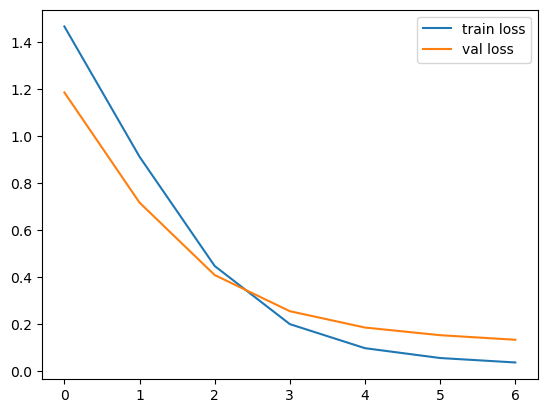

In [11]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

#last epoch looks good
# ofc val loss not as good as train loss as expected

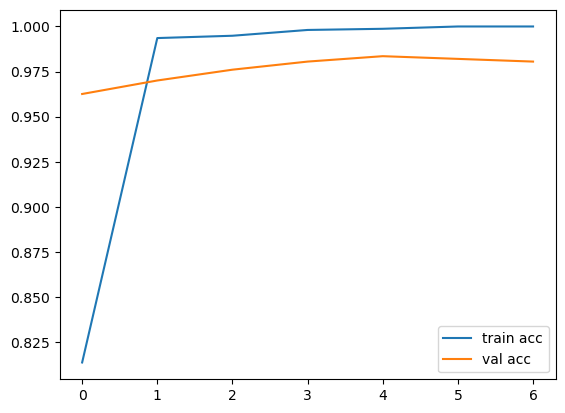

In [12]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

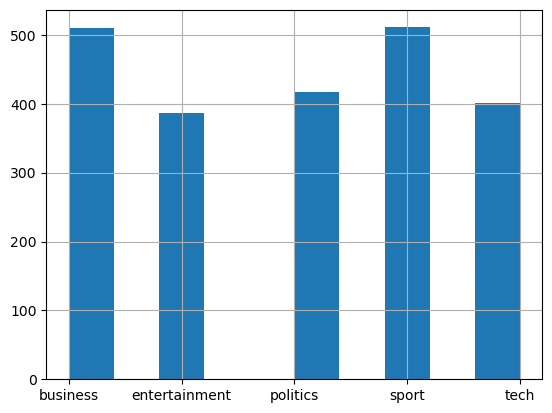

In [13]:
df['labels'].hist();

#since our labels are relatively balanced no ned to check AUC or F1

### Exercise Apply this to Sentiment Analysis
### also do binary : apply to spam as well. 

- remember the last time we did sentiment analysis with neuron we interpreted weights as well, higher weights were assigned to more important words etc.
- consider if the NN also has such interpretability